Fetching data from CoinGecko API...
Fetched 100 coins.
Preprocessing features...
Using features: ['current_price', 'market_cap_log', 'total_volume_log', 'price_change_percentage_24h_in_currency']
Data shape after preprocessing: (100, 4)

Finding optimal K using elbow and silhouette methods...


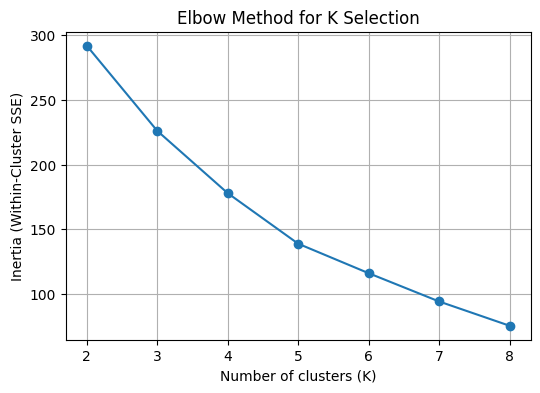

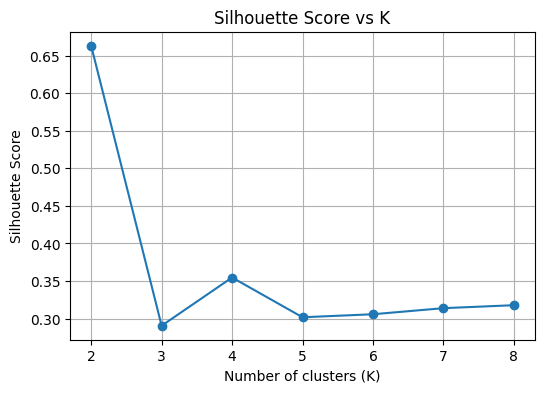


Training KMeans with K = 4...
Number of coins in each cluster:
cluster
0    24
1    69
2     3
3     4
Name: count, dtype: int64

Cluster-wise mean statistics:
         current_price    market_cap  total_volume  \
cluster                                              
0           630.746099  4.916333e+10  6.182930e+09   
1           394.045375  2.810209e+09  1.325359e+08   
2             0.711371  1.577517e+09  7.203737e+03   
3         91079.500000  4.598012e+11  1.903550e+10   

         price_change_percentage_24h_in_currency  
cluster                                           
0                                       3.355542  
1                                       1.596398  
2                                      -2.279220  
3                                       4.635469  

Sample coins from Cluster 0:
       name symbol  current_price    market_cap  total_volume  \
1  Ethereum    eth    3037.380000  367084181536  2.148816e+10   
2    Tether   usdt       0.999945  184555061039 

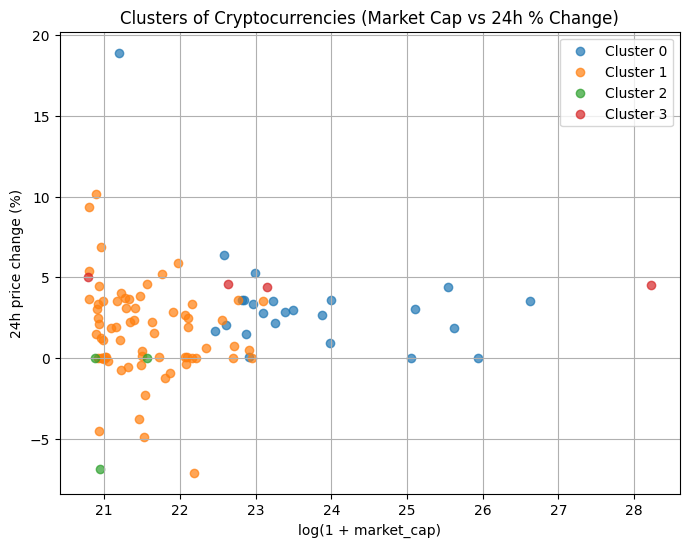

In [1]:

# K-Means Clustering Project with API-based Dataset (CoinGecko)


!pip install requests pandas scikit-learn matplotlib

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# 1. Fetch data from API


def fetch_crypto_data(per_page=100, vs_currency="usd"):
    """
    Fetch cryptocurrency market data from the CoinGecko API.
    Returns a pandas DataFrame.
    """
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": vs_currency,
        "order": "market_cap_desc",
        "per_page": per_page,
        "page": 1,
        "sparkline": "false",
        "price_change_percentage": "24h"
    }

    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

    data = response.json()
    df = pd.DataFrame(data)
    return df

# 2. Select and preprocess features


def preprocess_features(df):
    """
    Select relevant numeric features and preprocess them for K-means.
    Returns scaled_features (numpy array), scaler, and processed DataFrame.
    """

    features = [
        "current_price",
        "market_cap",
        "total_volume",
        "price_change_percentage_24h_in_currency"
    ]

    # Keep only needed columns + name/id for reference
    subset = df[["id", "symbol", "name"] + features].copy()

    # Drop rows with missing values in our selected features
    subset = subset.dropna(subset=features)

    # Log-transform highly skewed features (market_cap, total_volume)

    subset["market_cap_log"] = np.log1p(subset["market_cap"])
    subset["total_volume_log"] = np.log1p(subset["total_volume"])

    # Create final feature set used for clustering
    feature_cols = [
        "current_price",
        "market_cap_log",
        "total_volume_log",
        "price_change_percentage_24h_in_currency"
    ]

    X = subset[feature_cols].values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, scaler, subset, feature_cols

# 3. Choose K using elbow + silhouette (optional but good practice)


def find_optimal_k(X_scaled, k_min=2, k_max=10):
    """
    Compute inertia and silhouette scores for different K.
    Returns dict with Ks, inertias, and silhouette scores.
    """
    inertias = []
    silhouettes = []
    Ks = list(range(k_min, k_max + 1))

    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        inertia = kmeans.inertia_
        inertias.append(inertia)

        # Silhouette only makes sense for k >= 2 and number of samples > k
        if len(X_scaled) > k:
            sil = silhouette_score(X_scaled, labels)
        else:
            sil = np.nan
        silhouettes.append(sil)

    return {
        "Ks": Ks,
        "inertias": inertias,
        "silhouettes": silhouettes
    }

def plot_elbow_and_silhouette(results):
    Ks = results["Ks"]
    inertias = results["inertias"]
    silhouettes = results["silhouettes"]

    # Elbow plot
    plt.figure(figsize=(6, 4))
    plt.plot(Ks, inertias, marker="o")
    plt.xlabel("Number of clusters (K)")
    plt.ylabel("Inertia (Within-Cluster SSE)")
    plt.title("Elbow Method for K Selection")
    plt.grid(True)
    plt.show()

    # Silhouette plot
    plt.figure(figsize=(6, 4))
    plt.plot(Ks, silhouettes, marker="o")
    plt.xlabel("Number of clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs K")
    plt.grid(True)
    plt.show()

# 4. Train K-Means with chosen K


def run_kmeans(X_scaled, n_clusters=4):
    """
    Fit KMeans on the scaled data and return the model and labels.
    """
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)
    return kmeans, labels


# 5. Attach cluster labels back to coins and inspect clusters


def analyze_clusters(subset, labels):
    """
    Attach cluster labels to the subset DataFrame and print summary.
    """
    subset_with_clusters = subset.copy()
    subset_with_clusters["cluster"] = labels

    print("Number of coins in each cluster:")
    print(subset_with_clusters["cluster"].value_counts().sort_index())
    print("\nCluster-wise mean statistics:")
    print(subset_with_clusters.groupby("cluster")[[
        "current_price",
        "market_cap",
        "total_volume",
        "price_change_percentage_24h_in_currency"
    ]].mean())

    return subset_with_clusters

# 6. Visualize clusters (2D scatter using PCA-like feature choice)


def plot_clusters_2d(subset_with_clusters):
    """
    Simple 2D scatter plot using two meaningful features.
    X-axis: log(market cap)
    Y-axis: 24h price change %
    """
    plt.figure(figsize=(8, 6))

    for cluster_id in sorted(subset_with_clusters["cluster"].unique()):
        cluster_data = subset_with_clusters[subset_with_clusters["cluster"] == cluster_id]
        plt.scatter(
            np.log1p(cluster_data["market_cap"]),
            cluster_data["price_change_percentage_24h_in_currency"],
            label=f"Cluster {cluster_id}",
            alpha=0.7
        )

    plt.xlabel("log(1 + market_cap)")
    plt.ylabel("24h price change (%)")
    plt.title("Clusters of Cryptocurrencies (Market Cap vs 24h % Change)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 7. Main pipeline


def main():
    # Step 1: Fetch data
    print("Fetching data from CoinGecko API...")
    df = fetch_crypto_data(per_page=100, vs_currency="usd")
    print(f"Fetched {len(df)} coins.")

    # Step 2: Preprocess features
    print("Preprocessing features...")
    X_scaled, scaler, subset, feature_cols = preprocess_features(df)
    print(f"Using features: {feature_cols}")
    print(f"Data shape after preprocessing: {X_scaled.shape}")

    # Step 3: Find optimal K (optional, but useful)
    print("\nFinding optimal K using elbow and silhouette methods...")
    results = find_optimal_k(X_scaled, k_min=2, k_max=8)
    plot_elbow_and_silhouette(results)

    # ---- Choose K manually based on plots ----
    # For demo, let's set K = 4 (you can change this after inspecting the plots)
    chosen_k = 4
    print(f"\nTraining KMeans with K = {chosen_k}...")

    # Step 4: Run KMeans
    kmeans, labels = run_kmeans(X_scaled, n_clusters=chosen_k)

    # Step 5: Analyze clusters
    subset_with_clusters = analyze_clusters(subset, labels)

    # Show some sample coins from each cluster
    for c in sorted(subset_with_clusters["cluster"].unique()):
        print(f"\nSample coins from Cluster {c}:")
        print(subset_with_clusters[subset_with_clusters["cluster"] == c][
            ["name", "symbol", "current_price", "market_cap", "total_volume", "price_change_percentage_24h_in_currency"]
        ].head(5))

    # Step 6: Visualize clusters
    plot_clusters_2d(subset_with_clusters)


if __name__ == "__main__":
    main()
